In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import json
import os

sys.path.append(str(Path.cwd().parent))

from vae import dump
from src.load_model import load_model
import src.utils as utils

### Compare Models with diffrent latent dimensions

In [2]:
dataset = 'shapes'
# configure paths
models_path = f"../models/{dataset}"
dataset_path = f"../data/{dataset}"
dump_path = f"../dumps/{dataset}"

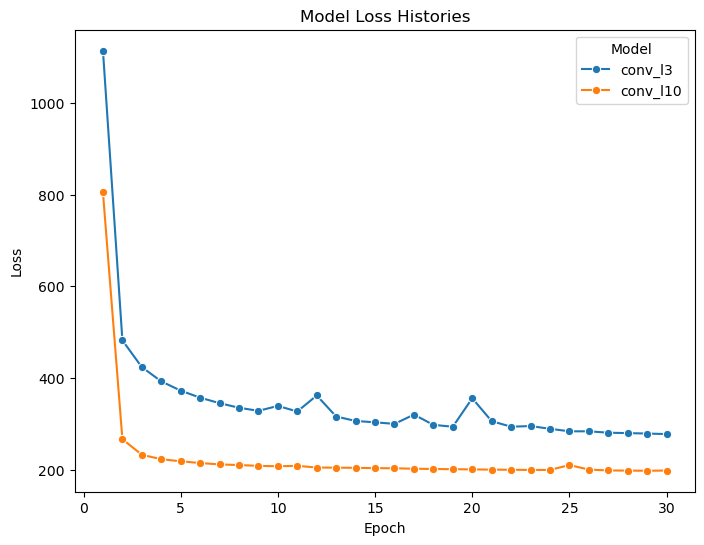

In [3]:
# Model comparison
loss_histories = []
# get dirs in models_path
models = os.listdir(models_path)

# Load loss histories from each model
for model in models:
    config = utils.load_model_config(os.path.join(models_path, model))
    loss_histories.append((model, config["loss_history"]))

# Prepare data for plotting
data = []
for model, history in loss_histories:
    for epoch, loss in enumerate(history):
        data.append({"Model": model, "Epoch": epoch + 1, "Loss": loss})

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Model", marker="o")
plt.title('Model Loss Histories')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Model')
plt.show()

Choose one of the models to look at:

In [4]:
chosen_model = "conv_l3"
model_path = os.path.join(models_path, chosen_model)
model, device = load_model(model_path)
config = utils.load_model_config(model_path)

if config["grayscale"]:
    plt.rcParams['image.cmap'] = "gray"

## Sample

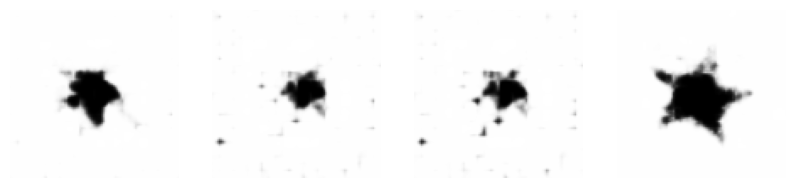

In [5]:
n = 4

plt.figure(figsize=(10, 5))

for i in range(n):
    output = model.sample(device)
    img = utils.convert_tensor_to_image(output)
    plt.subplot(1, n, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## Create CSV Dump

Create dump of dataset to visualize latent space

In [6]:
dump_file_path = os.path.join(dump_path, f"{chosen_model}.csv")

dump(model_path, input=dataset_path, save=dump_file_path)

Latent vectors saved to ../dumps/shapes/conv_l3.csv

In [7]:
# load dump
# dump_file_path = "../dumps/celeba/conv_l200.csv"

def load_dump(file_path):
    df = pd.read_csv(dump_file_path)

    # convert string to list
    df['mean'] = df['mean'].apply(json.loads)
    df['std'] = df['std'].apply(json.loads)
    
    return df

    # if dump was created at other path, change the path in the dump
    # df['path'] = df['path'].apply(lambda x: os.path.join("../", x))

df = load_dump(dump_file_path)

df.head()

,image,label,mean,std
0,circle/2350.png,circle,"[2.640685796737671, -3.8256609439849854, 0.891...","[0.012162120081484318, 0.007477267645299435, 0..."
1,circle/1893.png,circle,"[2.9135355949401855, -5.4879469871521, 2.49829...","[0.0134933702647686, 0.009557507932186127, 0.0..."
2,circle/1348.png,circle,"[1.293108582496643, -5.021057605743408, 3.7870...","[0.010282659903168678, 0.012775789946317673, 0..."
3,circle/1544.png,circle,"[1.775364875793457, -4.050973892211914, 4.6836...","[0.008020996116101742, 0.0069809481501579285, ..."
4,circle/381.png,circle,"[4.2729949951171875, -3.6441357135772705, 2.75...","[0.012847920879721642, 0.007789348252117634, 0..."


## Visuzalize the Reconstructed Image

[ 7550  4123    18  7762 13050]


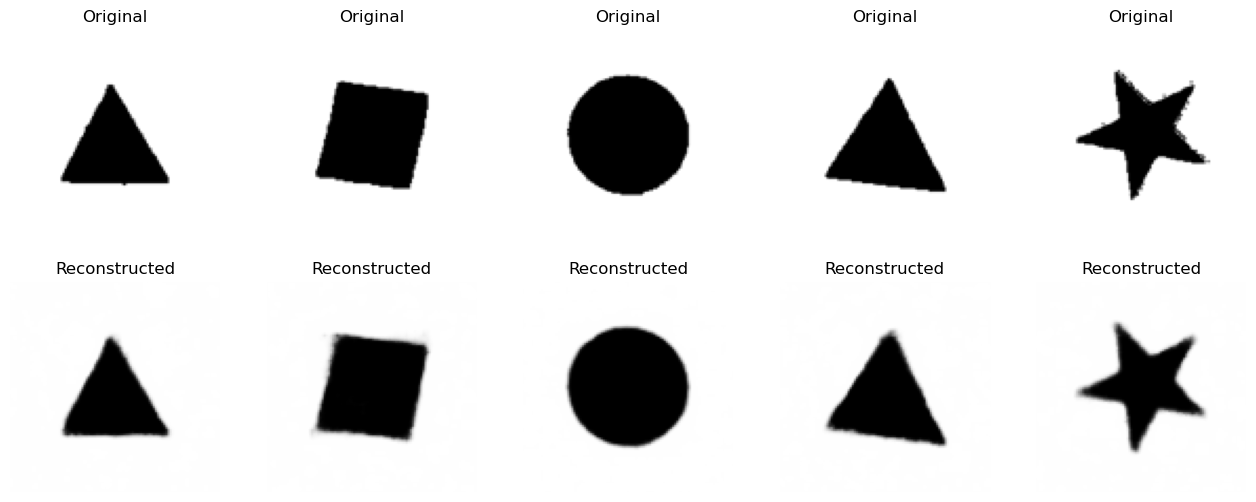

In [8]:
amount = 5
ids = np.random.choice(df.index, amount)
# [29609 25514  4554   915 11839]
print(ids)

plt.figure(figsize=(16, 6))

for i, id in enumerate(ids):
    org_img_path = os.path.join(dataset_path, df.iloc[id].image)
    mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
    epsilon = np.random.normal(0, 1, mean.shape)
    latent_vector = mean + epsilon * std
    # change dtype to float32
    latent_vector = np.array(latent_vector, dtype=np.float32)

    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    plt.subplot(2, amount, i+1)
    org_image = Image.open(org_img_path)
    if config.get("resize", None):
        org_image = org_image.resize(config["resize"])
    plt.imshow(org_image)
    plt.axis("off")
    plt.title("Original")
    plt.subplot(2, amount, i+1 + amount)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Reconstructed")

## Add Noise to the latent vector

2283


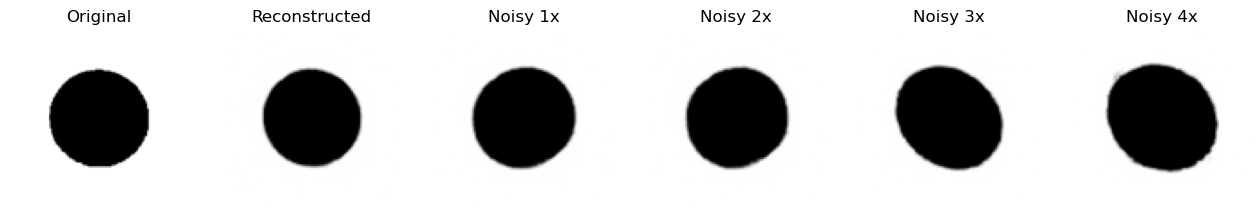

In [9]:
amount = 4
id = np.random.choice(df.index, 1)[0]
print(id)

plt.figure(figsize=(16, 6))
org_img_path =os.path.join(dataset_path, df.iloc[id].image)
mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
epsilon = np.random.normal(0, 1, mean.shape)
latent_vector = mean + epsilon * std
# change dtype to float32
latent_vector = np.array(latent_vector, dtype=np.float32)

output = model.generate(latent_vector, device)
image = utils.convert_tensor_to_image(output)
plt.subplot(1, amount+2, 1)
org_image = Image.open(org_img_path)
if config.get("resize", None):
    org_image = org_image.resize(config["resize"])
plt.imshow(org_image)
plt.axis("off")
plt.title("Original")
plt.subplot(1, amount+2, 2)
plt.imshow(image)
plt.axis("off")
plt.title("Reconstructed")

for i in range(amount):
    # add noise to the latent vector
    epsilon = np.random.normal(0, 1, latent_vector.shape)
    latent_vector += epsilon
    output = model.generate(latent_vector, device)
    image_noisy = utils.convert_tensor_to_image(output)
    plt.subplot(1, amount+2, i+3)
    plt.imshow(image_noisy)
    plt.axis("off")
    plt.title(f"Noisy {i+1}x")


## Interpolate

with gif

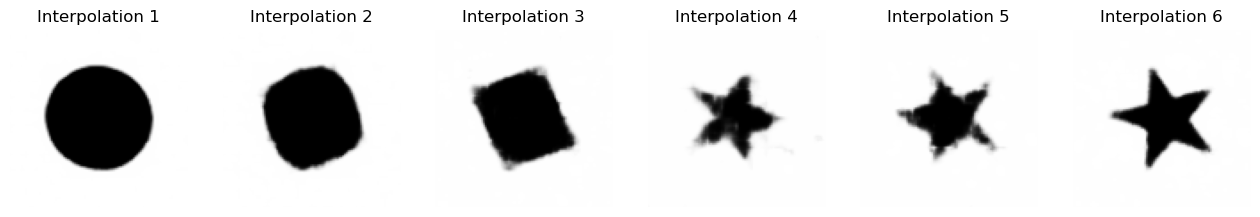

In [10]:
id_1, id_2 = 2262, 14734

def get_latent_vector(id, df):
    mean, std = np.array(df.iloc[id]["mean"]), np.array(df.iloc[id]["std"])
    epsilon = np.random.normal(0, 1, mean.shape)
    latent_vector = mean + epsilon * std
    latent_vector = np.array(latent_vector, dtype=np.float32)
    return latent_vector

latent_vector_1 = get_latent_vector(id_1, df)
latent_vector_2 = get_latent_vector(id_2, df)

# interpolate between two latent vectors
n = 6
latent_vectors = np.zeros((n, latent_vector_1.shape[0]), dtype=np.float32)
for i in range(n):
    # linear interpolation
    latent_vectors[i] = latent_vector_1 + (latent_vector_2 - latent_vector_1) * i / (n-1)
    
    
plt.figure(figsize=(16, 6))

for i, latent_vector in enumerate(latent_vectors):
    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    plt.subplot(1, n, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Interpolation {i+1}")

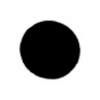

In [11]:
# id_1, id_2 = 23955, 28104

latent_vector_1 = get_latent_vector(id_1, df)
latent_vector_2 = get_latent_vector(id_2, df)

# interpolate between two latent vectors
n = 50
latent_vectors = np.zeros((n, latent_vector_1.shape[0]), dtype=np.float32)
for i in range(n):
    # linear interpolation
    latent_vectors[i] = latent_vector_1 + (latent_vector_2 - latent_vector_1) * i / (n-1)

# create gif
images = []
for i, latent_vector in enumerate(latent_vectors):
    output = model.generate(latent_vector, device)
    image = utils.convert_tensor_to_image(output)
    images.append(image)
    
gif_path = "../images/interpolation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=100, loop=0)

# show gif
from IPython.display import Image as IPImage
IPImage(filename=gif_path)

## Visualize 3D Lantent space with classes

In [12]:
from sklearn.decomposition import PCA

In [14]:
dump_file_path = "../dumps/shapes/conv_l3.csv"
df = load_dump(dump_file_path)

# create  dataframe to plot the latent space
# select samples from each class
sample_per_class = 200
df_sample = df.groupby("label").sample(sample_per_class, random_state=42)
df_sample = df_sample.reset_index(drop=True)

# for each sample create latent_vector and do PCA, store in new df

latent_vectors = []
for i, row in df_sample.iterrows():
    mean, std = np.array(row["mean"]), np.array(row["std"])
    epsilon = np.random.normal(0, 1, mean.shape)
    latent_vector = mean + epsilon * std
    latent_vectors.append(latent_vector)

latent_vectors = np.array(latent_vectors)

# Reduce to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(latent_vectors)

# create new df
df_pca = pd.DataFrame(latent_vectors, columns=["PC1", "PC2", "PC3"])
# place label at first column
df_pca["label"] = df_sample["label"].values

df_pca.tail()

,PC1,PC2,PC3,label
795,4.503770,0.706879,-7.600808,triangle
796,-0.355720,-3.726500,-6.248427,triangle
797,-3.587321,-2.142491,-2.077171,triangle
798,4.114759,0.450159,-4.749158,triangle
799,2.339505,-1.423154,-1.866669,triangle


In [15]:
import plotly.express as px

def plot_interactive_latent_space(df):
    fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='label', 
                        color_discrete_sequence=px.colors.qualitative.D3)

    fig.update_traces(marker=dict(size=4))
    fig.show()
    
plot_interactive_latent_space(df_pca)

In [ ]:
# Plotting with Seaborn and Matplotlib

def plot_latent_space(df_pca):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a color palette
    palette = sns.color_palette("hsv", df_pca["label"].nunique())
    color_mapping = {label: palette[i] for i, label in enumerate(df_pca["label"].unique())}
    colors = df_pca["label"].map(color_mapping)

    scatter = ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"], c=colors, s=20)

    # Set axis labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Create a custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in range(len(palette))]
    labels = df_pca["label"].unique()
    ax.legend(handles, labels, title="Label")

    plt.show()
    
# plot_latent_space(df_pca)

### Add random image into the model

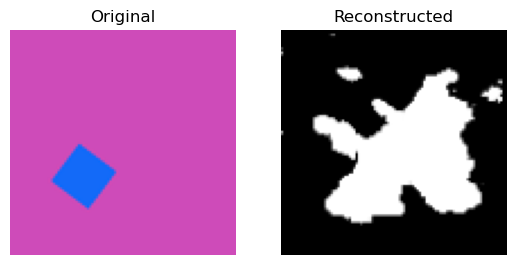

In [ ]:
# diff_image_path = "../data/celeba/faces/096752.jpg"
diff_image_path = "../data/shapes-color/Square/Square_88d79a74-2a98-11ea-8123-8363a7ec19e6.png"


image = utils.image_to_tensor(
            diff_image_path, resize=config.get("resize", None), grayscale=config["grayscale"]
        )
mean, std = model.dump_latent(image, device)
epsilon = np.random.normal(0, 1, mean.shape)
latent_vector = mean + epsilon * std
latent_vector = np.array(latent_vector, dtype=np.float32)

output = model.generate(latent_vector, device)

diff_image = utils.convert_tensor_to_image(output)

plt.subplot(1, 2, 1)
org_image = Image.open(diff_image_path).resize(config["resize"])
plt.imshow(org_image)
plt.axis("off")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(diff_image)
plt.axis("off")
plt.title("Reconstructed")

plt.show()

In [ ]:
latent_vectors = np.append(latent_vectors, [latent_vector], axis=0)
df_sample.loc[len(df_sample.index)] = {"image": diff_image_path, "label": "diff", "mean": mean, "std": std}

# Reduce to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(latent_vectors)

# create new df
df_pca = pd.DataFrame(reduced_data, columns=["PC1", "PC2", "PC3"])
# place label at first column
df_pca["label"] = df_sample["label"].values

plot_interactive_latent_space(df_pca)